# Py: Investigating Neural Network Biases with ChatGPT
**But not in the way you think...**

*An Analytics Snippet By Jacky Poon.*

In this notebook we will use the assistance of ChatGPT to use neural network models with early stopping to predict claims data and see if it is biased. 

Here, bias is referring to the model making predictions that are systematically higher or lower. This is important because in many practical actuarial applications, whilst it is helpful to be able to predict which are the high risk segments and which are the low risk segments, having the whole portfolio systematically underpriced or overpriced will lead to unfortunate outcomes.

We will see if we can replicate similar findings to [Wuthrich 2019](https://deliverypdf.ssrn.com/delivery.php?ID=448116089123102082100070125118102081056087054032028010066007099074002097073008122030002122118022114055124103026123081099112073014010033010014103098079094065083077001060023103066064099006069008009080006124020127072025027006000127097096066026103089113&EXT=pdf&INDEX=TRUE). In the paper Wuthrich describes how use of the early stopping technique to limit over-fitting introduced biases into estimates of the mean, and considers the use of regularisation techniques to prevent this. 

Early stopping is a common method in machine learning to prevent overfitting. You select a validation dataset and then during the model training process, if we observe at some point that further training is not improving performance, we stop. 

Our investigation follows [my earlier notebook](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/post/research/chain_ladder_to_individual_mdn/). In the article we described how to make incremental changes to a chain ladder to progress to a probabilistic neural network. We also shared several techniques that help the model training process, with faster convergence and better stability. In that notebook, early stopping was not used, so estimates aligned well to the mean within the training data. Instead, regularisation was used to try to prevent overfitting. However, regularisation requires hyperparameter searches to find the value that finds the right balance between under- and over-fitting, whereas early stopping would seem to automatically find the right balance. 

So it would be interesting to test to see if the Wuthrich findings of biases apply to our approach as well. 

## ChatGPT prompt:

We used the following prompt to start our code. 

> Write a python script that fits a feedforward neural network with one hidden layer on a ``pandas`` tabular dataset. 
> Use ``pytorch``, with early stopping. 
> The response column is ``claims``. 
> There is an exposure weight column ``expo``.
> Numerical features are ``age``, ``ac``, ``power``, ``dens`` 
> Categorical features are ``gas``, ``brand``, ``area``, and ``ct``.
> Explain the code.

This was run on ChatGPT's free version in mid May 2023. You may get different output as the large language model does not appear to be deterministic - different runs will produce different code, sometimes a different style, and often different bugs or functionality.

We will include ChatGPT's code descriptions, which were originally at the end, in-line with the code in *italics* to make it easier to follow, and annotate any adjustments we made. 

## Response:
*Certainly! Below is a Python script that fits a feedforward neural network with embeddings on categorical features and one hidden layer using PyTorch on a Pandas tabular dataset:*

*Import the necessary libraries, including torch for deep learning operations, numpy for numerical computations, and pandas for data manipulation.*

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler  # We added MinMaxScaler for later
from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt  # Added this for extra diagnostics. 


In [2]:
num_models = 50

*Define a class called `FeedForwardNet`, which represents the feedforward neural network model. It inherits from the `nn.Module` class, the base class for all neural network modules in PyTorch.*

*Inside the FeedForwardNet class, define the neural network architecture in the __init__ method. It consists of an embedding layer for each categorical feature, followed by a hidden layer and an output layer.*

*Implement the forward pass of the neural network in the forward method. The forward pass involves embedding the categorical features, concatenating them with the numerical features, and passing the concatenated tensor through the hidden and output layers.*

The prompt does a good job and produces what is asked for. There is an undocumented dropout layer with 20% dropout which was not part of the ask, which we will take out to simplify the logic. 

In Wuthrich's paper, a multi-layer network is used with (20, 15, 10) hidden neurons, in our prompt we have only asked for a single hidden layer. We can change this to take a list of hidden sizes by asking:
 > Modify this code to take in a list of hidden layer sizes for a multi-layer model:
and including the code for the `FeedForwardNet` class. 

We also make some amendments based on our earlier work. 

In our prompt, we neglected to mention we wanted to add an exponential transform at the end to have non-negative estimates analogous to a log-link GLM, so we amend the code to add `torch.exp` at end.

Additionally, we initialise as follows to improve model training:
 * Final layer weights to zero
 * Final layer bias to an additional parameter `init_bias`.

In [3]:

# Define the neural network class
class FeedForwardNet(nn.Module):
    def __init__(self, num_numerical_feats, num_categorical_feats, embedding_sizes, hidden_sizes, init_bias):  # was hidden_size originally
        super(FeedForwardNet, self).__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_classes, emb_size) for num_classes, emb_size in embedding_sizes
        ])
        self.num_numerical_feats = num_numerical_feats
        self.num_categorical_feats = num_categorical_feats
        self.total_embed_size = sum([emb_size for _, emb_size in embedding_sizes])
        self.input_size = self.num_numerical_feats + self.total_embed_size

        # self.fc1 = nn.Linear(self.input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([
            nn.Linear(self.input_size if i == 0 else hidden_sizes[i - 1], hidden_size)
            for i, hidden_size in enumerate(hidden_sizes)
        ])

        # self.fc2 = nn.Linear(hidden_size, 1)
        self.fc2 = nn.Linear(hidden_sizes[-1], 1)

        nn.init.zeros_(self.fc2.weight)                          # Initialise to zero
        self.fc2.bias.data = torch.tensor(init_bias)
        # self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x_numerical, x_categorical):
        embedded_x = [embedding(x_categorical[:, i]) for i, embedding in enumerate(self.embeddings)]
        embedded_x = torch.cat(embedded_x, dim=1)
        x = torch.cat([embedded_x, x_numerical], dim=1)
        # x = self.dropout(x)
        # x = torch.relu(self.fc1(x))

        for hidden_layer in self.hidden_layers:
            x = torch.relu(hidden_layer(x))

        # x = self.dropout(x)
        x = self.fc2(x)
        return torch.exp(x)      #Exp output


*Load the dataset using `pd.read_csv()` and split it into training and validation sets using `train_test_split()` from `scikit-learn`.*

We did not give the dataset a file, so it was naming it by a placeholder `'your_dataset.csv'`. We are using the data from [Wu ̈thrich–Buser](https://deliverypdf.ssrn.com/delivery.php?ID=843106086008086077095022066099066010017051024001008020124118114123013023071031125091049101001060018038058118064065031070081123109034011046042121019015100116121004041055094020008081109098014124081007088083009088118030071102107101005121114105115096099&EXT=pdf&INDEX=TRUE), the link is [here](https://people.math.ethz.ch/~wmario/Lecture/MTPL_data.csv).

In [4]:
# Load the dataset
data = pd.read_csv("MTPL_data.csv", sep=";").set_index("id")

# Split the dataset into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)


The dataset looks like this by the way:

In [5]:
data

,claims,expo,age,ac,power,gas,brand,area,dens,ct,truefreq
id,,,,,,,,,,,
1,0,0.33,66,4,3,Regular,B12,B,83,BE,0.059941
2,0,0.08,31,1,7,Diesel,B1,A,34,BL,0.119216
3,0,0.92,60,6,5,Diesel,B1,C,223,AG,0.074344
4,0,1.00,66,4,2,Diesel,B1,C,283,FR,0.092829
5,0,0.63,63,3,5,Regular,B12,B,74,VS,0.049981
...,...,...,...,...,...,...,...,...,...,...,...
499996,0,0.15,32,3,2,Diesel,B1,C,204,FR,0.100843
499997,0,0.86,40,2,2,Regular,B12,D,617,FR,0.167433
499998,0,0.74,46,7,4,Regular,B1,C,238,VD,0.084457


*Define the categorical features and numerical features based on the dataset columns.*
 
*Encode the categorical features using `LabelEncoder()` from scikit-learn. This is necessary to convert the categorical features into numerical representations suitable for training the neural network.*

ChatGPT lists the features as instructed, but we discover after the fact that Wuthrich has area as continuous, so we'll adjust the code accordingly.

We'll create the label encoders based on the full dataset instead of the training dataset only, to avoid errors from missing levels.

In [6]:

# Define the categorical features and numerical features
categorical_feats = ['gas', 'brand', 'area', 'ct']
numerical_feats = ['age', 'ac', 'power', 'dens']

# Encode the categorical features using LabelEncoder
label_encoders = {}
for feat in categorical_feats:
    label_encoders[feat] = LabelEncoder()
    label_encoders[feat].fit(data[feat])
    train_data[feat] = label_encoders[feat].transform(train_data[feat])
    val_data[feat] = label_encoders[feat].transform(val_data[feat])


ChatGPT only label encodes the categorical variables, but we should standardise our numerical inputs:

In [7]:
# Standardize the categorical features using LabelEncoder
scaler = {}
for feat in numerical_feats:
    scaler[feat] = MinMaxScaler()
    train_data[feat] = scaler[feat].fit_transform(train_data[feat].values.reshape(-1, 1))
    val_data[feat] = scaler[feat].transform(val_data[feat].values.reshape(-1, 1))


*Define the embedding sizes for each categorical feature. These sizes determine the dimensions of the embedding vectors for each categorical feature. Usually, the embedding size is chosen to be smaller than the number of unique values in the feature but larger than half of it.*


In [8]:

# Define the embedding sizes for categorical features
embedding_sizes = [(len(train_data[feat].unique()), min(50, (len(train_data[feat].unique()) + 1) // 2)) for feat in categorical_feats]


 *Convert the dataset columns into PyTorch tensors, which are required for training the neural network model.*

 We neglected to mention this in the prompt, but we actually want to divide claims by exposure here to get y.

In [9]:

# Convert the dataset to PyTorch tensors
x_train_numerical = torch.tensor(train_data[numerical_feats].values, dtype=torch.float32)
x_train_categorical = torch.tensor(train_data[categorical_feats].values, dtype=torch.long)
# y_train = torch.tensor(train_data['claims'].values, dtype=torch.float32)
y_train = torch.tensor(train_data['claims'].values / train_data['expo'].values, dtype=torch.float32)
exposure_train = torch.tensor(train_data['expo'].values, dtype=torch.float32)

x_val_numerical = torch.tensor(val_data[numerical_feats].values, dtype=torch.float32)
x_val_categorical = torch.tensor(val_data[categorical_feats].values, dtype=torch.long)
# y_val = torch.tensor(val_data['claims'].values, dtype=torch.float32)
y_val = torch.tensor(val_data['claims'].values / val_data['expo'].values, dtype=torch.float32)
exposure_val = torch.tensor(val_data['expo'].values, dtype=torch.float32)


We did not mention it in the prompt, but let's calculate our mean so that we can see that it is aligning to that value. 

In [10]:
avg_claim = train_data['claims'].values.sum() / train_data['expo'].values.sum()
avg_claim

0.10265948983820225

In [11]:
(y_train * exposure_train).sum() / train_data['expo'].values.sum()

tensor(0.1027)

*Define the hyperparameters such as the hidden layer size, learning rate, batch size, number of epochs, and early stopping epochs.*

The `batch_size` is generated, but it does not look like it is actually used in the later generated code. We prefer using the whole dataset, so this is fine. 

We make a few adjustments to hyperparams.
 

In [12]:
# Define the hyperparameters
# hidden_size = 64
hidden_size = [20, 15, 10]  # Replace with the multi-layer parameters.

# learning_rate = 0.001
# batch_size = 32
# num_epochs = 100
# early_stopping_epochs = 10

# Overwrite those hyperparameters with these
learning_rate = 0.01
num_epochs = 9999  # should not be a factor, we train until early stopping kicks in
early_stopping_epochs = 10


*Create an instance of the FeedForwardNet model.*

We pass on the `init_bias` parameter here.

In [13]:
# Create an instance of the FeedForwardNet model
model = FeedForwardNet(len(numerical_feats), len(categorical_feats), embedding_sizes, hidden_size, init_bias = np.log(avg_claim).astype(np.float32))

# Test that the init_bias works, what is the initial mean?
y_pred = model(x_train_numerical, x_train_categorical)

(y_pred.squeeze() * exposure_train).sum() / exposure_train.sum()

tensor(0.1027, grad_fn=<DivBackward0>)


*Define the loss function (mean squared error) and the optimizer (Adam optimizer) to train the model.*

We would like to do the exposure weights a little differently. We will have reduction='none' and keep the loss output as individual loss values per row instead of the sum. This allows us to multiply the loss per record by the exposure weight per record later. 

We'll also swap to Poisson Loss.


In [14]:
# Define the loss function
# criterion = nn.MSELoss(reduction='sum')

criterion = nn.PoissonNLLLoss(reduction='none', log_input=False)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

*Train the model for the specified number of epochs. In each epoch, perform forward and backward passes, update the model's parameters, and calculate the validation loss. If the validation loss is the lowest so far, save the model's state.*

We add some debug output for diagnostics.

In [15]:
# Train the model
best_val_loss = np.inf
best_epoch = 0
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(x_train_numerical, x_train_categorical)
    # loss = criterion(y_pred.squeeze() * exposure_train, y_train * exposure_train)
    loss = (criterion(y_pred.squeeze(), y_train) * exposure_train).sum() / exposure_train.sum()
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        y_val_pred = model(x_val_numerical, x_val_categorical)
        # val_loss = criterion(y_val_pred.squeeze() * exposure_val, y_val * exposure_val)
        val_loss = (criterion(y_val_pred.squeeze(), y_val) * exposure_val).sum() / exposure_val.sum()
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')
    
    # Added for diagnostics
    if (val_loss < best_val_loss) | (epoch % 10 == 0):
        print(
            "Epoch:", epoch,
            "Train_Diff:", ((y_pred.squeeze() * exposure_train - y_train * exposure_train).sum() / exposure_train.sum()).item(),            
            "Train_Mean:", ((y_pred.squeeze() * exposure_train).sum() / exposure_train.sum()).item(), 
            "Train_Loss", loss.item(),
            "Val_mean", ((y_val_pred.squeeze() * exposure_val).sum() / exposure_val.sum()).item(), 
            "Val_loss", val_loss.item(),
        )

    if epoch - best_epoch >= early_stopping_epochs:
        print("Stopping at:", best_epoch)      
        break


Epoch: 0 Train_Diff: 3.9570383081333205e-10 Train_Mean: 0.10265947878360748 Train_Loss 0.33634716272354126 Val_mean 0.10276821255683899 Val_loss 0.336696594953537
Epoch: 10 Train_Diff: 0.0005192473763599992 Train_Mean: 0.10317873954772949 Train_Loss 0.3340966999530792 Val_mean 0.10280803591012955 Val_loss 0.3345138132572174
Epoch: 20 Train_Diff: 0.000555766629986465 Train_Mean: 0.10321525484323502 Train_Loss 0.3329228162765503 Val_mean 0.10316438227891922 Val_loss 0.3333604633808136
Epoch: 30 Train_Diff: 0.00022463459754362702 Train_Mean: 0.10288412868976593 Train_Loss 0.33167240023612976 Val_mean 0.10189294815063477 Val_loss 0.33199846744537354
Epoch: 40 Train_Diff: 0.00515005411580205 Train_Mean: 0.10780954360961914 Train_Loss 0.33076417446136475 Val_mean 0.09964833408594131 Val_loss 0.33111655712127686
Epoch: 50 Train_Diff: -0.0002511663769837469 Train_Mean: 0.10240831226110458 Train_Loss 0.3297358453273773 Val_mean 0.10654579848051071 Val_loss 0.33056363463401794
Epoch: 60 Train_Di

*Load the best model's state from the saved file.*

In [16]:
# Load the best model
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

*Prepare the test set data and make predictions on it using the best model.*

ChatGPT does not actually prepare the test set data, so we need to code this up ourselves. For this test we'll just use our original full dataset.

In [17]:
test_data = data.copy()
for feat in categorical_feats:
    test_data[feat] = label_encoders[feat].transform(test_data[feat])

for feat in numerical_feats:
    test_data[feat] = scaler[feat].transform(test_data[feat].values.reshape(-1, 1))

*Calculate the test loss (mean squared error) and the root mean squared error (RMSE) for the test set.*

*Print the test RMSE.*

In [18]:
# Make predictions on the test set
x_test_numerical = torch.tensor(test_data[numerical_feats].values, dtype=torch.float32)
x_test_categorical = torch.tensor(test_data[categorical_feats].values, dtype=torch.long)
y_test = torch.tensor(test_data['claims'].values, dtype=torch.float32)
exposure_test = torch.tensor(test_data['expo'].values, dtype=torch.float32)

model.eval()
with torch.no_grad():
    y_test_pred = model(x_test_numerical, x_test_categorical)

# Calculate the test loss
# test_loss = criterion(y_test_pred.squeeze() * exposure_test, y_test * exposure_test)
test_loss = (criterion(y_test_pred.squeeze(), y_test) * exposure_test).sum() / exposure_test.sum()
test_rmse = torch.sqrt(test_loss.item() / torch.tensor(len(test_data)))

print(f'Test RMSE: {test_rmse:.4f}')

Test RMSE: 0.0007


*This code fits a feedforward neural network with embeddings on categorical features and one hidden layer using PyTorch. It uses early stopping to prevent overfitting and achieves predictions for the response column "claims" in a tabular dataset.*

Let us run some diagnostics on this model, on the validation data:

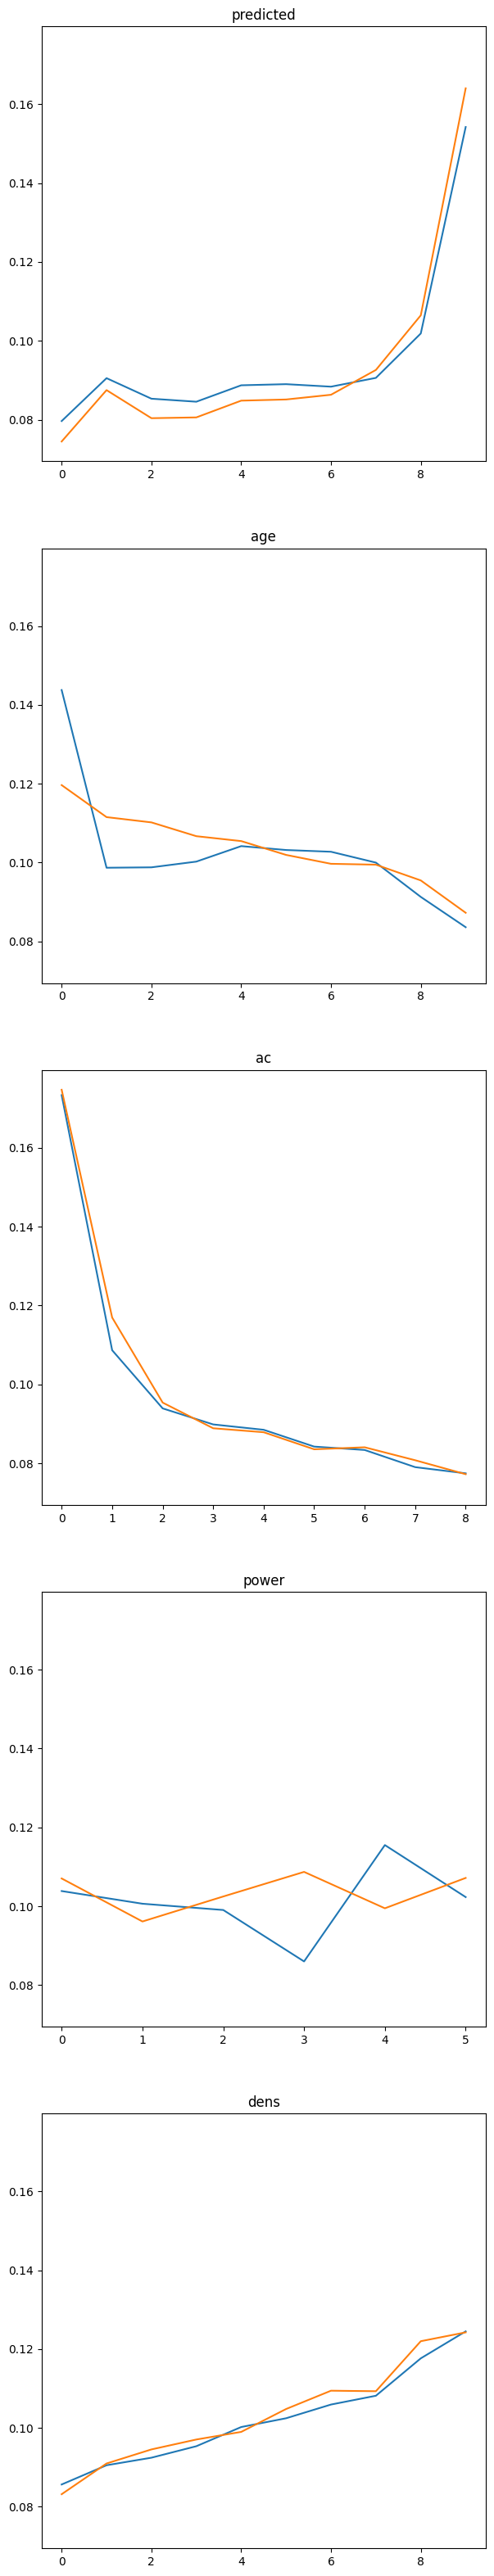

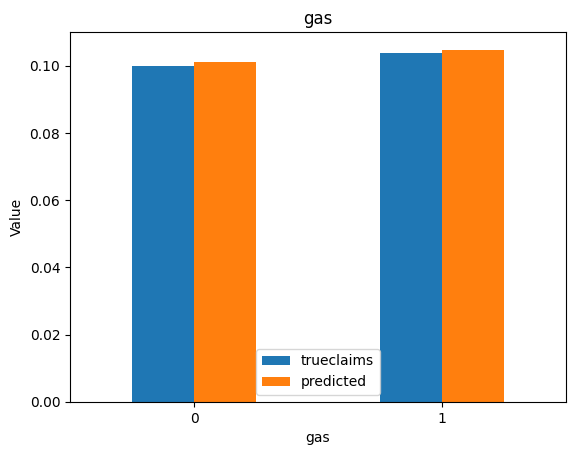

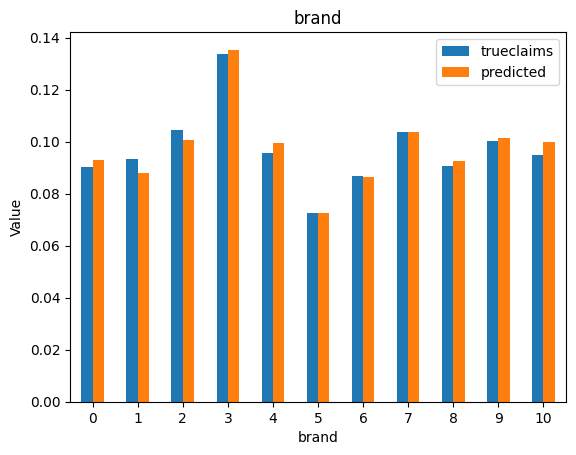

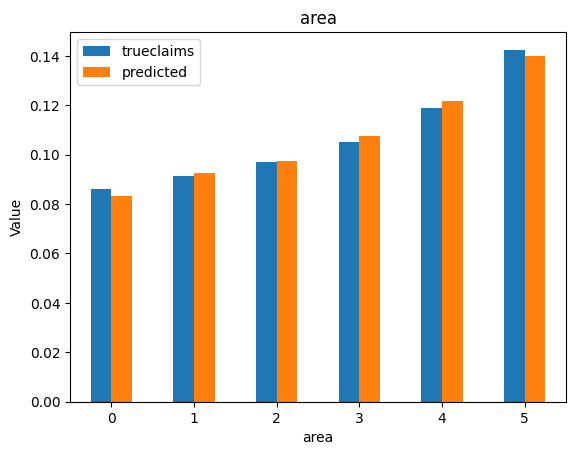

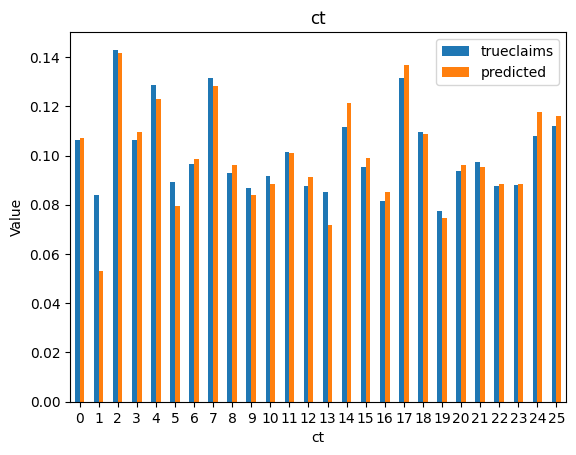

In [19]:
y_val_pred = model(x_val_numerical, x_val_categorical)

val_data["predicted"] = y_val_pred.cpu().detach().numpy().ravel() * val_data.expo
val_data["trueclaims"] = val_data.truefreq * val_data.expo

fig, axs = plt.subplots(len(numerical_feats) + 1, sharex=False, sharey=True, figsize=(7, 40))

for i, f in enumerate(["predicted"] + numerical_feats):
    dat_copy = val_data.copy()
    dat_copy["decile"] = pd.qcut(dat_copy[f], 10, labels=False, duplicates='drop')
    X_sum = dat_copy.groupby("decile").agg("sum").reset_index()
    
    axs[i].plot(X_sum.index, X_sum.trueclaims / X_sum.expo)
    axs[i].plot(X_sum.index, X_sum.predicted / X_sum.expo)    
    axs[i].set_title(f)


for i, f in enumerate(categorical_feats):
    dat_copy = val_data.copy()
    X_sum = dat_copy.groupby(f).agg("sum")[["trueclaims", "predicted", "expo"]]
    X_sum["trueclaims"] = X_sum["trueclaims"]/X_sum["expo"]
    X_sum["predicted"] = X_sum["predicted"]/X_sum["expo"]
    X_sum = X_sum.drop(columns="expo")
    axs[i] = X_sum.plot(kind='bar', rot=0, xlabel=f, ylabel='Value', title=f)


So we have a working model with the assistance of ChatGPT. The code suggestions by the model were generally good, but sometimes subtlely wrong. We still needed an understanding of the mechanics of fitting a neural network on tabular data in order to debug the code generated by the LLM, and to recognise and include any requirements missed in our original prompt. Overall, use of generative AI made the development of this notebook considerably faster.



Onto the experiment on bias:

## Experiment on Bias

We run the training loop 50 times to get a model. We check whether the model predicts an average frequency that matches the (1) training set on which it was fitted and (2) the true underlying frequency. We resample train/test each time so that the sampling does not skew the result. 

In [20]:
results = []
weight_list = []

for i in range(0, num_models):
    # Resample - Split the dataset into training and validation sets
    train_data, val_data = train_test_split(data, test_size=0.2)
    
    for feat in categorical_feats:
        train_data[feat] = label_encoders[feat].transform(train_data[feat])
        val_data[feat] = label_encoders[feat].transform(val_data[feat])

    for feat in numerical_feats:
        scaler[feat] = MinMaxScaler()
        train_data[feat] = scaler[feat].fit_transform(train_data[feat].values.reshape(-1, 1))
        val_data[feat] = scaler[feat].transform(val_data[feat].values.reshape(-1, 1))

    # Convert the dataset to PyTorch tensors
    x_train_numerical = torch.tensor(train_data[numerical_feats].values, dtype=torch.float32)
    x_train_categorical = torch.tensor(train_data[categorical_feats].values, dtype=torch.long)
    # y_train = torch.tensor(train_data['claims'].values, dtype=torch.float32)
    y_train = torch.tensor(train_data['claims'].values / train_data['expo'].values, dtype=torch.float32)
    exposure_train = torch.tensor(train_data['expo'].values, dtype=torch.float32)

    x_val_numerical = torch.tensor(val_data[numerical_feats].values, dtype=torch.float32)
    x_val_categorical = torch.tensor(val_data[categorical_feats].values, dtype=torch.long)
    # y_val = torch.tensor(val_data['claims'].values, dtype=torch.float32)
    y_val = torch.tensor(val_data['claims'].values / val_data['expo'].values, dtype=torch.float32)
    exposure_val = torch.tensor(val_data['expo'].values, dtype=torch.float32)

    # Create an instance of the FeedForwardNet model
    model = FeedForwardNet(len(numerical_feats), len(categorical_feats), embedding_sizes, hidden_size, init_bias = np.log(avg_claim).astype(np.float32))

    criterion = nn.PoissonNLLLoss(reduction='none', log_input=False)

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    best_val_loss = np.inf
    best_epoch = 0
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(x_train_numerical, x_train_categorical)
        # loss = criterion(y_pred.squeeze() * exposure_train, y_train * exposure_train)
        loss = (criterion(y_pred.squeeze(), y_train) * exposure_train).sum() / exposure_train.sum()
        loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            y_val_pred = model(x_val_numerical, x_val_categorical)
            # val_loss = criterion(y_val_pred.squeeze() * exposure_val, y_val * exposure_val)
            val_loss = (criterion(y_val_pred.squeeze(), y_val) * exposure_val).sum() / exposure_val.sum()
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_weights = model.state_dict().copy()
            torch.save(best_weights, 'best_model.pt')

            best_result = {
                "Epoch": epoch,
                "Train_Diff": ((y_pred.squeeze() * exposure_train - y_train * exposure_train).sum() / exposure_train.sum()).item(),            
                "Train_Mean": ((y_pred.squeeze() * exposure_train).sum() / exposure_train.sum()).item(), 
                "Train_Loss": loss.item(),
                "Val_mean": ((y_val_pred.squeeze() * exposure_val).sum() / exposure_val.sum()).item(), 
                "Val_loss": val_loss.item(),
                "Mean": 0.8*((y_pred.squeeze() * exposure_train).sum() / exposure_train.sum()).item() + 0.2*((y_val_pred.squeeze() * exposure_val).sum() / exposure_val.sum()).item()
            }
        
        if epoch - best_epoch >= early_stopping_epochs:
            results += [best_result]
            break

    weight_list.append(best_weights)


In [21]:
pd.DataFrame(results)

,Epoch,Train_Diff,Train_Mean,Train_Loss,Val_mean,Val_loss,Mean
0,130,-0.000645,0.102177,0.325923,0.100916,0.326849,0.101925
1,112,0.001128,0.104126,0.326204,0.100970,0.325138,0.103495
2,100,-0.011181,0.091365,0.329277,0.104439,0.330272,0.093980
3,144,0.003659,0.106545,0.326212,0.101356,0.326794,0.105507
4,149,-0.001328,0.100622,0.323909,0.103777,0.334216,0.101253
5,143,-0.000898,0.101453,0.325552,0.102908,0.330316,0.101744
6,121,-0.002593,0.099565,0.324868,0.103678,0.332443,0.100387
7,99,0.004969,0.107395,0.325997,0.101939,0.330895,0.106304
8,175,-0.001557,0.101031,0.324581,0.102687,0.328301,0.101362
9,103,-0.001491,0.101537,0.326496,0.101486,0.325832,0.101527


So, are our 50 neural networks making biased predictions vs their training sets?

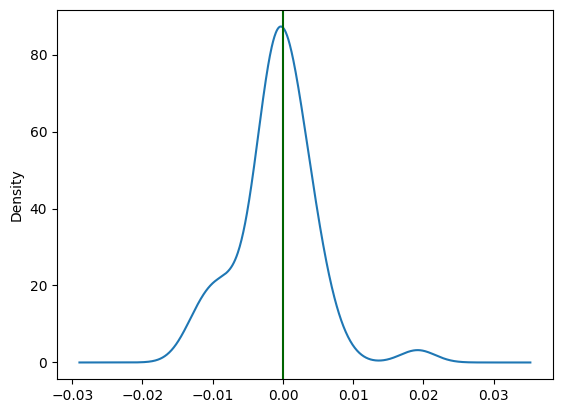

In [22]:
pd.DataFrame(results).Train_Diff.plot.kde()
plt.axvline(x = 0.0, color = 'darkgreen')

In [23]:
bias_std = pd.DataFrame(results).Train_Diff.std()
pd.DataFrame(results).Train_Diff.mean(), pd.DataFrame(results).Train_Diff.std()

(-0.0008891218338976614, 0.005435967840328695)

Training runs do appear to match on average, the mean frequency of the training dataset.
However early stopping appears to lead to models that are sometimes predicting higher and sometimes predicting lower. 

How does the model go in matching the true and dataset means?

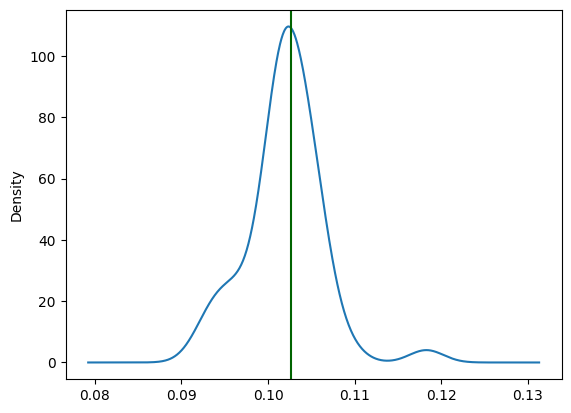

In [24]:
pd.DataFrame(results).Mean.plot.kde()
plt.axvline(x = avg_claim, color = 'darkgreen')

Models predict near the mean values, but there is some variabilty of the predictions around it. 

Overall, with help from ChatGPT, we appear to have replicated the finding from the Wuthrich paper that early stopping can lead to the biased models. On average, models predict at near the correct average levels, but individual models may predict with some variability around that level - they are biased. None of this is new or original but ChatGPT was quite helpful in being to recreate this analysis in Python (Wuthrich appears to have used R). 

Currently our average validation loss is:

In [25]:
avg_val_loss = pd.DataFrame(results).Val_loss.mean()
avg_val_loss

0.32853454232215884

## Solving the bias issue

Wuthrich suggests regularization approaches to reduce the bias. See Section 4 in his [paper](https://deliverypdf.ssrn.com/delivery.php?ID=312025116122114123096127007073121120117035019009034090074026123081067081117096067101096034023121015125114118022102077067077095059082053065068066072013007113086088071086042026121006066004001110017094030007030086079127114066096116006064022127099103006&EXT=pdf&INDEX=TRUE).

Wuthrich in his [other work](https://deliverypdf.ssrn.com/delivery.php?ID=576121020003020092097100025085064064032043077033024024075121124067085065070083096000011050026016049049112005112104113127090028048026026076017093095012093109083070084075000006018069083020001093127069023083082095067068083098094095090115031073119125083&EXT=pdf&INDEX=TRUE) also discusses ensembling approach in Section 5.1.6. Here the 50 models have a variability in the overall predicted levels, but on average they are right. So if we were to take the final model as the ensemble average of the 50 models, it would average out the bias issue.

In [26]:
# Average neural network prediction:
avg_nn_prediction = pd.DataFrame(results).Mean.mean()
# Average frequency in dataset
avg_frequency = data['claims'].values.sum() / data['expo'].values.sum()
# True underlying frequency 
true_frequency = (data['truefreq'] * data['expo']).values.sum() / data['expo'].values.sum()

print("Average neural network prediction:", avg_nn_prediction)
print("Average frequency in dataset:", avg_frequency)
print("True underlying frequency:", true_frequency)
print("Averaged prediction vs true frequency:", avg_nn_prediction / true_frequency)

Average neural network prediction: 0.10194956490397454
Average frequency in dataset: 0.10269062235781508
True underlying frequency: 0.10199107887858037
Averaged prediction vs true frequency: 0.9995929646488468


### Learn Rates
Another idea from other neural network work is to [apply a higher learn rate solely on the bias](https://datascience.stackexchange.com/questions/23549/why-is-the-learning-rate-for-the-bias-usually-twice-as-large-as-the-the-lr-for-t).

The idea is to allow the bias to converge on its true value faster, before the other weights begin to overfit, triggering the early stopping and halting training. 

In [27]:
hidden_size = [20, 15, 10]  # Replace with the multi-layer parameters.

num_epochs = 99999  # should not be a factor, we train until early stopping kicks in
early_stopping_epochs = 10

learning_rate = 0.005      # Half base learning rate
bias_learning_rate = 0.05  # Increased bias learning rate

The training loop is updated with the optimizer applying this higher learning rate to the one bias value.

In [28]:
results = []
weight_list = []

for i in range(0, num_models):
    # Resample - Split the dataset into training and validation sets
    train_data, val_data = train_test_split(data, test_size=0.2)
    
    for feat in categorical_feats:
        train_data[feat] = label_encoders[feat].transform(train_data[feat])
        val_data[feat] = label_encoders[feat].transform(val_data[feat])

    for feat in numerical_feats:
        scaler[feat] = MinMaxScaler()
        train_data[feat] = scaler[feat].fit_transform(train_data[feat].values.reshape(-1, 1))
        val_data[feat] = scaler[feat].transform(val_data[feat].values.reshape(-1, 1))

    # Convert the dataset to PyTorch tensors
    x_train_numerical = torch.tensor(train_data[numerical_feats].values, dtype=torch.float32)
    x_train_categorical = torch.tensor(train_data[categorical_feats].values, dtype=torch.long)
    # y_train = torch.tensor(train_data['claims'].values, dtype=torch.float32)
    y_train = torch.tensor(train_data['claims'].values / train_data['expo'].values, dtype=torch.float32)
    exposure_train = torch.tensor(train_data['expo'].values, dtype=torch.float32)

    x_val_numerical = torch.tensor(val_data[numerical_feats].values, dtype=torch.float32)
    x_val_categorical = torch.tensor(val_data[categorical_feats].values, dtype=torch.long)
    # y_val = torch.tensor(val_data['claims'].values, dtype=torch.float32)
    y_val = torch.tensor(val_data['claims'].values / val_data['expo'].values, dtype=torch.float32)
    exposure_val = torch.tensor(val_data['expo'].values, dtype=torch.float32)

    # Create an instance of the FeedForwardNet model
    model = FeedForwardNet(len(numerical_feats), len(categorical_feats), embedding_sizes, hidden_size, init_bias = np.log(avg_claim).astype(np.float32))

    criterion = nn.PoissonNLLLoss(reduction='none', log_input=False)

    # Bias specific learn rates
    my_list = ['fc2.bias']
    bias_params = list(filter(lambda kv: kv[0] in my_list, model.named_parameters()))
    base_params = list(filter(lambda kv: kv[0] not in my_list, model.named_parameters()))

    # Define the optimizer
    # optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    optimizer = optim.Adam([
                {'params': [temp[1] for temp in base_params]},
                {'params': [temp[1] for temp in bias_params], 'lr': bias_learning_rate}
            ], lr=learning_rate)

    # Train the model
    best_val_loss = np.inf
    best_epoch = 0

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(x_train_numerical, x_train_categorical)
        # loss = criterion(y_pred.squeeze() * exposure_train, y_train * exposure_train)
        loss = (criterion(y_pred.squeeze(), y_train) * exposure_train).sum() / exposure_train.sum()
        loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            y_val_pred = model(x_val_numerical, x_val_categorical)
            # val_loss = criterion(y_val_pred.squeeze() * exposure_val, y_val * exposure_val)
            val_loss = (criterion(y_val_pred.squeeze(), y_val) * exposure_val).sum() / exposure_val.sum()
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_weights = model.state_dict().copy()
            torch.save(best_weights, 'best_model.pt')

            best_result = {
                "Epoch": epoch,
                "Train_Diff": ((y_pred.squeeze() * exposure_train - y_train * exposure_train).sum() / exposure_train.sum()).item(),            
                "Train_Mean": ((y_pred.squeeze() * exposure_train).sum() / exposure_train.sum()).item(), 
                "Train_Loss": loss.item(),
                "Val_mean": ((y_val_pred.squeeze() * exposure_val).sum() / exposure_val.sum()).item(), 
                "Val_loss": val_loss.item(),
                "Mean": 0.8*((y_pred.squeeze() * exposure_train).sum() / exposure_train.sum()).item() + 0.2*((y_val_pred.squeeze() * exposure_val).sum() / exposure_val.sum()).item()
            }
        
        if epoch - best_epoch >= early_stopping_epochs:
            results += [best_result]            
            break

    weight_list.append(best_weights)        

In [29]:
# check we have the right parameter
bias_params

[('fc2.bias',
  Parameter containing:
  tensor(-2.1823, requires_grad=True))]

So how do results look with this?

In [30]:
pd.DataFrame(results)

,Epoch,Train_Diff,Train_Mean,Train_Loss,Val_mean,Val_loss,Mean
0,205,0.002327,0.104974,0.325422,0.101117,0.328724,0.104203
1,168,0.000035,0.102497,0.325165,0.101048,0.330128,0.102208
2,208,0.001107,0.103627,0.324849,0.102306,0.330064,0.103363
3,194,-0.002439,0.100004,0.325384,0.104841,0.329106,0.100971
4,216,-0.002707,0.099631,0.324795,0.104469,0.329759,0.100599
5,155,-0.004103,0.098337,0.325339,0.103473,0.330643,0.099364
6,173,0.001059,0.104135,0.326621,0.102555,0.323889,0.103819
7,239,0.000795,0.103905,0.325969,0.101931,0.323872,0.103510
8,219,-0.000637,0.102157,0.325523,0.102171,0.325915,0.102160
9,168,0.002321,0.105407,0.326163,0.101906,0.324060,0.104707


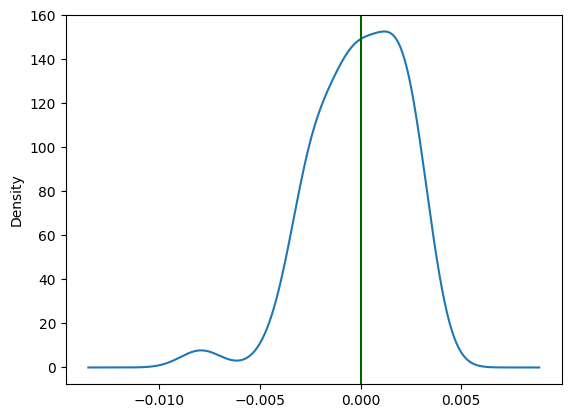

In [31]:
pd.DataFrame(results).Train_Diff.plot.kde()
plt.axvline(x = 0.0, color = 'darkgreen')

In [32]:
new_bias_std = pd.DataFrame(results).Train_Diff.std()
pd.DataFrame(results).Train_Diff.mean(), pd.DataFrame(results).Train_Diff.std()

(-6.771093656425364e-05, 0.0022470243173901318)

Compare the standard deviation of the bias with the bias-specific learning rate compared with the same learning rate across both.

In [33]:
new_bias_std / bias_std

0.41336232726024763


We can see with the abve result that the increased bias-specific learn rate was successful in reducing the variance in the overall model bias.

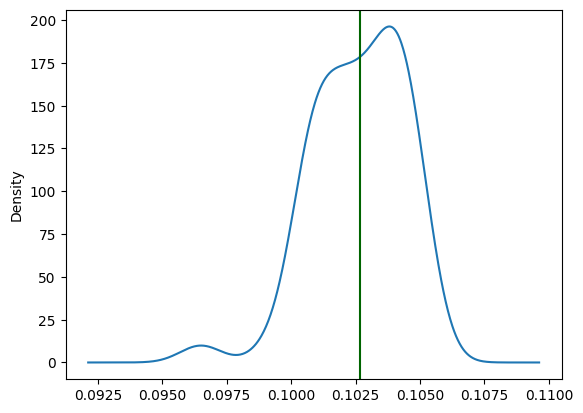

In [34]:
pd.DataFrame(results).Mean.plot.kde()
plt.axvline(x = avg_claim, color = 'darkgreen')

In [35]:
(
    # Average neural network prediction:
    pd.DataFrame(results).Mean.mean(), 
    # Average frequency in dataset
    data['claims'].values.sum() / data['expo'].values.sum(),
    # True underlying frequency 
    (data['truefreq'] * data['expo']).values.sum() / data['expo'].values.sum(),
)

(0.10261997532844544, 0.10269062235781508, 0.10199107887858037)

Predicted mean frequency for the models look to track near the training data mean more consistently.

Finally, the validation loss. Unlike regularisation, which is known to shape the segmentation predictions, conceptually a higher learn rate for the bias should just mean the training loop focuses on getting a more aligned bias estimate. Does this come through in our result?

In [36]:
fast_bias_val_loss = pd.DataFrame(results).Val_loss.mean()
fast_bias_val_loss

0.32791590332984927

In [37]:
fast_bias_val_loss - avg_val_loss

-0.0006186389923095725

The experiments are random so results may vary if this is re-run but for this run, val loss was similar.

Look at the diagnostics again. This will be on the last model of the batch that was trained. 

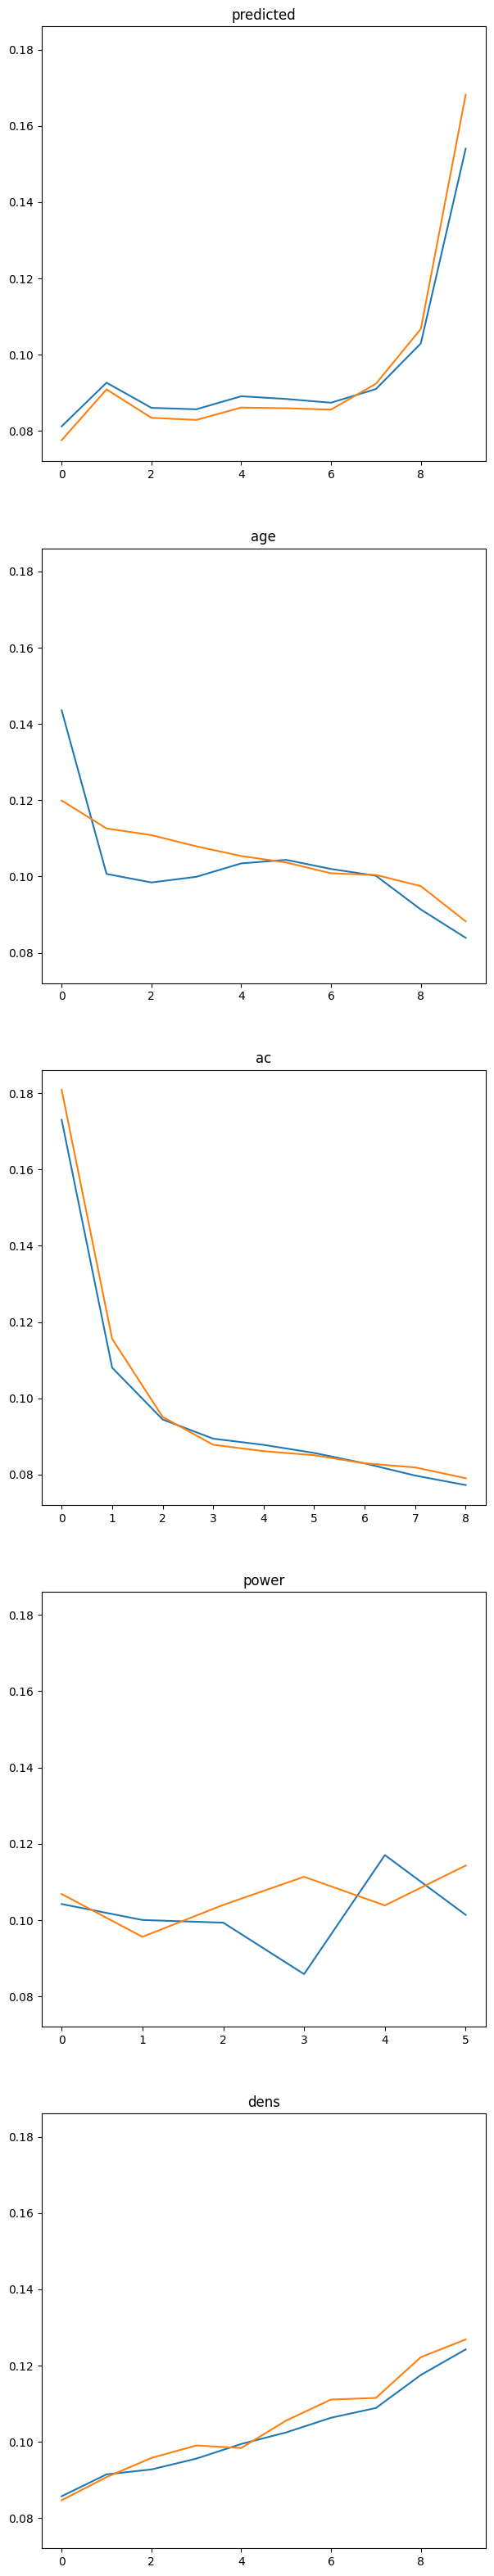

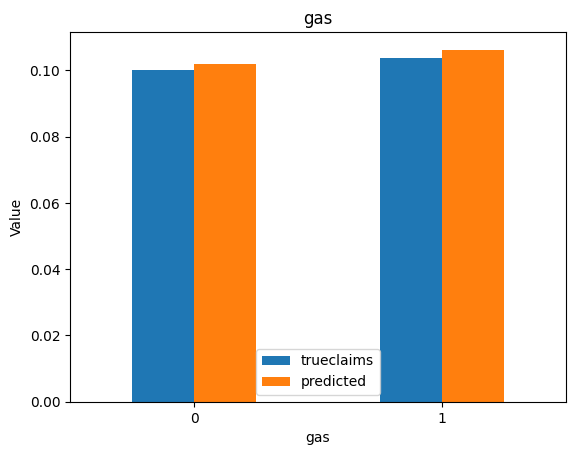

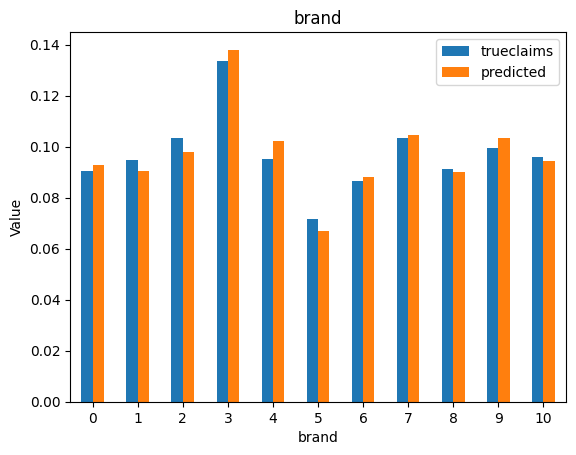

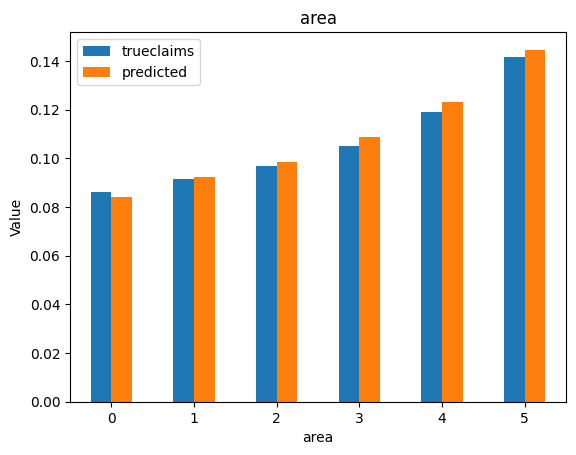

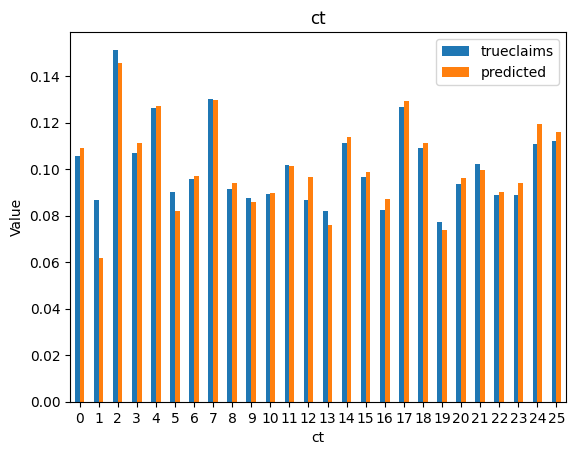

In [38]:
# Load the best model in the last run
model.load_state_dict(torch.load('best_model.pt'))

y_val_pred = model(x_val_numerical, x_val_categorical)

val_data["predicted"] = y_val_pred.cpu().detach().numpy().ravel() * val_data.expo
val_data["trueclaims"] = val_data.truefreq * val_data.expo

fig, axs = plt.subplots(len(numerical_feats) + 1, sharex=False, sharey=True, figsize=(7, 40))

for i, f in enumerate(["predicted"] + numerical_feats):
    dat_copy = val_data.copy()
    dat_copy["decile"] = pd.qcut(dat_copy[f], 10, labels=False, duplicates='drop')
    X_sum = dat_copy.groupby("decile").agg("sum").reset_index()
        
    axs[i].plot(X_sum.index, X_sum.trueclaims / X_sum.expo)
    axs[i].plot(X_sum.index, X_sum.predicted / X_sum.expo)
    axs[i].set_title(f)


for i, f in enumerate(categorical_feats):
    dat_copy = val_data.copy()
    X_sum = dat_copy.groupby(f).agg("sum")[["trueclaims", "predicted", "expo"]]
    X_sum["trueclaims"] = X_sum["trueclaims"]/X_sum["expo"]
    X_sum["predicted"] = X_sum["predicted"]/X_sum["expo"]
    X_sum = X_sum.drop(columns="expo")
    axs[i] = X_sum.plot(kind='bar', rot=0, xlabel=f, ylabel='Value', title=f)

Diagnostics still look good.

## Just change the bias

In [Wuthrich 2023](https://deliverypdf.ssrn.com/delivery.php?ID=576121020003020092097100025085064064032043077033024024075121124067085065070083096000011050026016049049112005112104113127090028048026026076017093095012093109083070084075000006018069083020001093127069023083082095067068083098094095090115031073119125083&EXT=pdf&INDEX=TRUE), he proposes (Section 5.1.5) the idea of training a GLM to full convergence with the final hidden layer weights and biases from the neural network to solve the bias issue. 

Finally, if having an unbiased model with early stopping is a must have, with `pytorch` we have full control over the training loop.

We could just explicitly set bias after every epoch to the value that keeps the predicted mean to be the mean of the training data.

In [39]:
# Define the hyperparameters
hidden_size = [20, 15, 10]  # Replace with the multi-layer parameters.
learning_rate = 0.01
num_epochs = 9999  # should not be a factor, we train until early stopping kicks in
early_stopping_epochs = 10

In [40]:
results = []
weight_list = []

for i in range(0, num_models):
    # Resample - Split the dataset into training and validation sets
    train_data, val_data = train_test_split(data, test_size=0.2)
    
    for feat in categorical_feats:
        train_data[feat] = label_encoders[feat].transform(train_data[feat])
        val_data[feat] = label_encoders[feat].transform(val_data[feat])

    for feat in numerical_feats:
        scaler[feat] = MinMaxScaler()
        train_data[feat] = scaler[feat].fit_transform(train_data[feat].values.reshape(-1, 1))
        val_data[feat] = scaler[feat].transform(val_data[feat].values.reshape(-1, 1))

    # Convert the dataset to PyTorch tensors
    x_train_numerical = torch.tensor(train_data[numerical_feats].values, dtype=torch.float32)
    x_train_categorical = torch.tensor(train_data[categorical_feats].values, dtype=torch.long)

    y_train = torch.tensor(train_data['claims'].values / train_data['expo'].values, dtype=torch.float32)
    exposure_train = torch.tensor(train_data['expo'].values, dtype=torch.float32)

    x_val_numerical = torch.tensor(val_data[numerical_feats].values, dtype=torch.float32)
    x_val_categorical = torch.tensor(val_data[categorical_feats].values, dtype=torch.long)

    y_val = torch.tensor(val_data['claims'].values / val_data['expo'].values, dtype=torch.float32)
    exposure_val = torch.tensor(val_data['expo'].values, dtype=torch.float32)

    # Create an instance of the FeedForwardNet model
    model = FeedForwardNet(len(numerical_feats), len(categorical_feats), embedding_sizes, hidden_size, init_bias = np.log(avg_claim).astype(np.float32))

    criterion = nn.PoissonNLLLoss(reduction='none', log_input=False)

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    best_val_loss = np.inf
    best_epoch = 0
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(x_train_numerical, x_train_categorical)
        loss = (criterion(y_pred.squeeze(), y_train) * exposure_train).sum() / exposure_train.sum()
        loss.backward()
        optimizer.step()     
        model.eval()

        # Adjust the bias each epoch
        with torch.no_grad():
            # Get predictions
            y_pred = model(x_train_numerical, x_train_categorical)

            # Get adjustment
            adjustment = torch.log((y_train * exposure_train).sum()) - torch.log((y_pred.squeeze() * exposure_train).sum())

        model.fc2.bias.data += adjustment 

        # Adjusted y_pred
        y_pred = model(x_train_numerical, x_train_categorical)

        with torch.no_grad():
            y_val_pred = model(x_val_numerical, x_val_categorical)
            val_loss = (criterion(y_val_pred.squeeze(), y_val) * exposure_val).sum() / exposure_val.sum()
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_weights = model.state_dict().copy()
            torch.save(best_weights, 'best_model.pt')

            best_result = {
                "Epoch": epoch,
                "Train_Diff": ((y_pred.squeeze() * exposure_train - y_train * exposure_train).sum() / exposure_train.sum()).item(),            
                "Train_Mean": ((y_pred.squeeze() * exposure_train).sum() / exposure_train.sum()).item(), 
                "Train_Loss": loss.item(),
                "Val_mean": ((y_val_pred.squeeze() * exposure_val).sum() / exposure_val.sum()).item(), 
                "Val_loss": val_loss.item(),
                "Mean": 0.8*((y_pred.squeeze() * exposure_train).sum() / exposure_train.sum()).item() + 0.2*((y_val_pred.squeeze() * exposure_val).sum() / exposure_val.sum()).item()
            }
        
        if epoch - best_epoch >= early_stopping_epochs:
            results += [best_result]
            break

    weight_list.append(best_weights)

In [41]:
pd.DataFrame(results)

,Epoch,Train_Diff,Train_Mean,Train_Loss,Val_mean,Val_loss,Mean
0,122,2.392140e-09,0.102556,0.324907,0.102498,0.328764,0.102544
1,97,-2.860957e-08,0.102573,0.325711,0.102370,0.329056,0.102533
2,103,-1.143877e-08,0.102153,0.324566,0.102151,0.332670,0.102152
3,100,2.330167e-08,0.103220,0.326741,0.103121,0.323224,0.103200
4,114,1.104944e-08,0.102778,0.326044,0.103099,0.326367,0.102842
5,137,-3.339519e-08,0.102181,0.324399,0.102149,0.333316,0.102175
6,105,5.588781e-08,0.102945,0.326395,0.103071,0.325628,0.102970
7,151,-4.614875e-08,0.102484,0.324409,0.102470,0.329613,0.102481
8,97,4.902244e-10,0.102397,0.325335,0.101848,0.329740,0.102287
9,109,-5.120140e-08,0.102658,0.325921,0.102671,0.328305,0.102660


So as expected, `Train_diff` is now zero - the predicted mean for all our models is exactly the same as the training data mean, because we set it that way.

But do we lose any predictive power from this?

In [42]:
fixed_bias_val_loss = pd.DataFrame(results).Val_loss.mean()
print(fixed_bias_val_loss, avg_val_loss, fixed_bias_val_loss - avg_val_loss)

0.32818478763103487 0.32853454232215884 -0.0003497546911239713


Let us also look at some diagnostics:

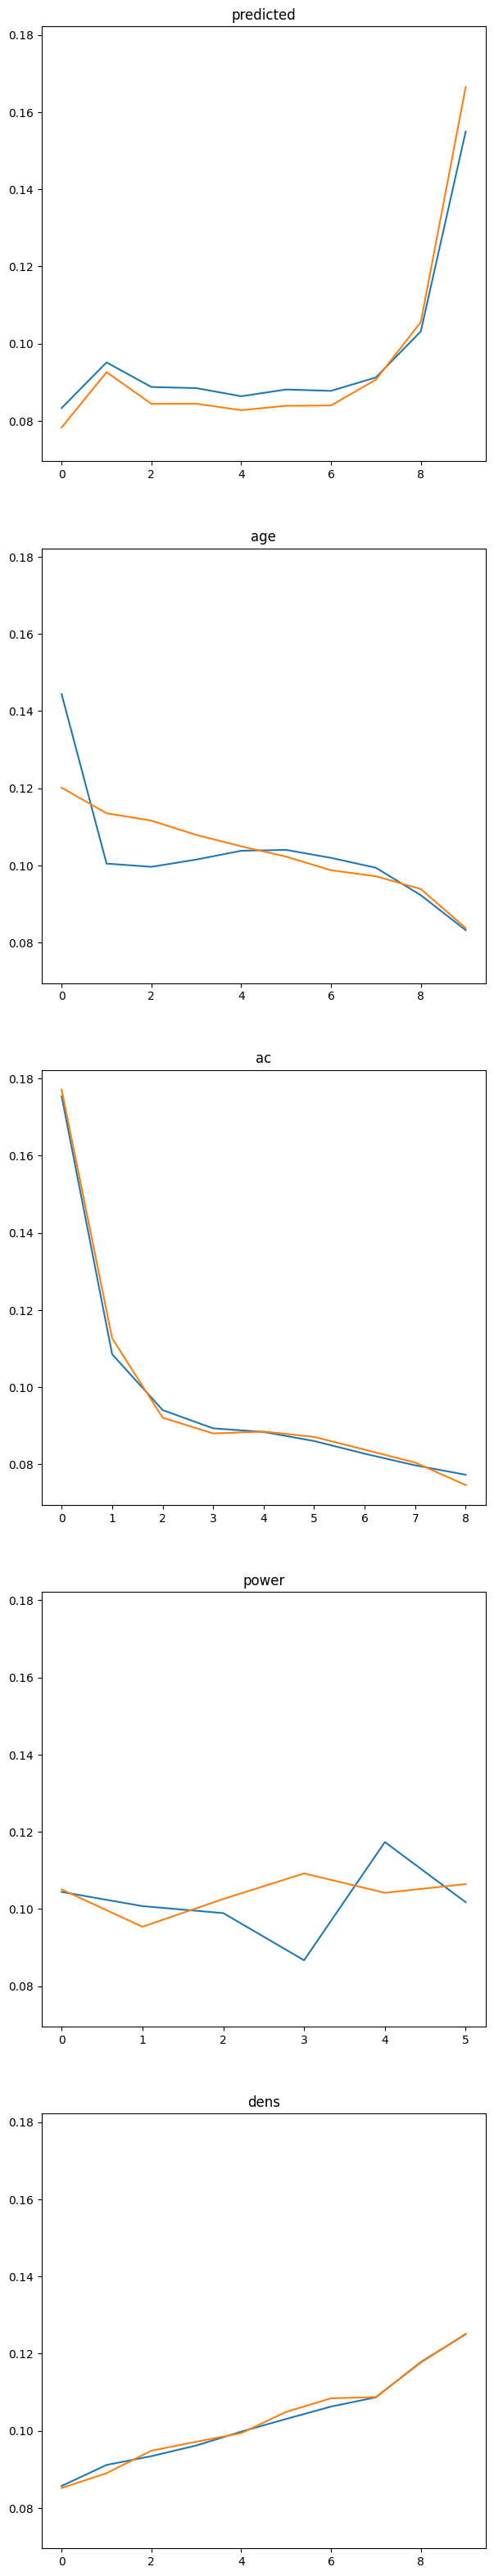

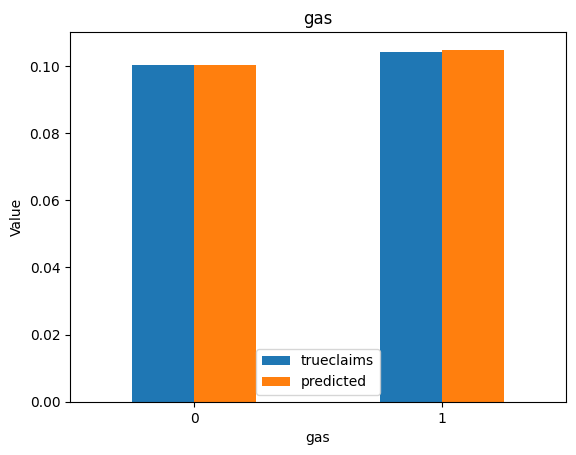

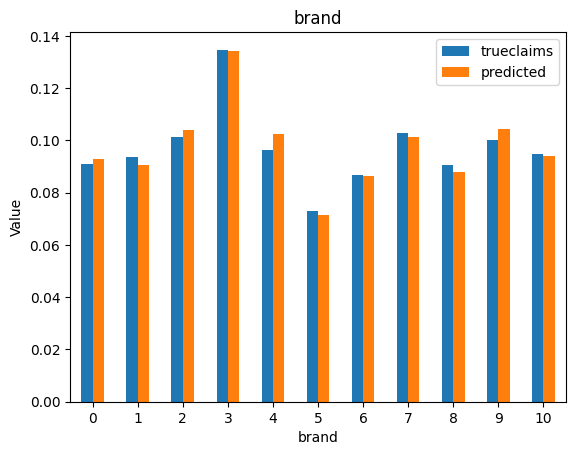

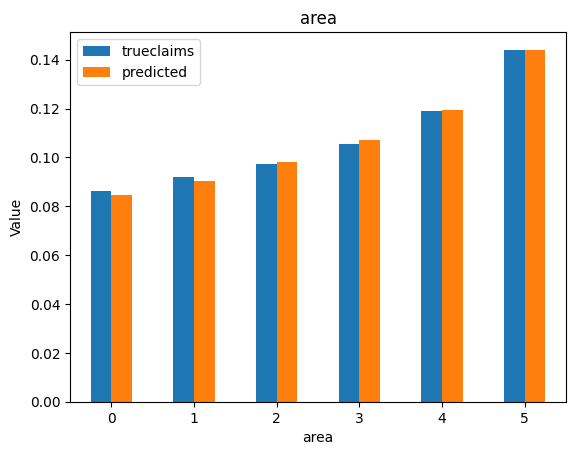

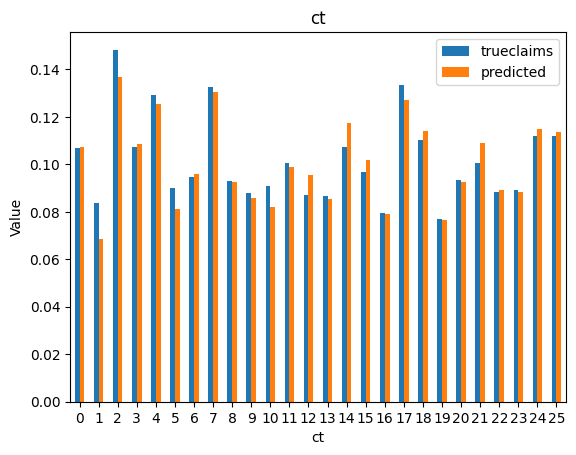

In [43]:
# Load the best model in the last run
model.load_state_dict(torch.load('best_model.pt'))

y_val_pred = model(x_val_numerical, x_val_categorical)

val_data["predicted"] = y_val_pred.cpu().detach().numpy().ravel() * val_data.expo
val_data["trueclaims"] = val_data.truefreq * val_data.expo

fig, axs = plt.subplots(len(numerical_feats) + 1, sharex=False, sharey=True, figsize=(7, 40))

for i, f in enumerate(["predicted"] + numerical_feats):
    dat_copy = val_data.copy()
    dat_copy["decile"] = pd.qcut(dat_copy[f], 10, labels=False, duplicates='drop')
    X_sum = dat_copy.groupby("decile").agg("sum").reset_index()
        
    axs[i].plot(X_sum.index, X_sum.trueclaims / X_sum.expo)
    axs[i].plot(X_sum.index, X_sum.predicted / X_sum.expo)
    axs[i].set_title(f)


for i, f in enumerate(categorical_feats):
    dat_copy = val_data.copy()
    X_sum = dat_copy.groupby(f).agg("sum")[["trueclaims", "predicted", "expo"]]
    X_sum["trueclaims"] = X_sum["trueclaims"]/X_sum["expo"]
    X_sum["predicted"] = X_sum["predicted"]/X_sum["expo"]
    X_sum = X_sum.drop(columns="expo")
    axs[i] = X_sum.plot(kind='bar', rot=0, xlabel=f, ylabel='Value', title=f)

## Conclusions

 * ChatGPT is an effective tool for accelerating actuarial data science programming. However, users need to have sufficient understanding to debug the resulting generated code, and identify any subtle logic errors, additional requirements, or best practices.
 * Early stopping does lead to models that are biased. The bias itself is not biased, it averages around the mean, but any given model may be biased.
 
 We propose other ideas to avoid this other than the solution proposed by Wuthrich.
 * Ensemble a group of models, which will average out biases. 
 * Increase the learning rate on the bias to ensure that remains close to the right levels. Note that our initialisation strategy means the bias already starts at the right level. 
 * Reset the bias so the mean reconciles after each epoch


## Appendix: Unedited ChatGPT code output

```
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# Define the neural network class
class FeedForwardNet(nn.Module):
    def __init__(self, num_numerical_feats, num_categorical_feats, embedding_sizes, hidden_size):
        super(FeedForwardNet, self).__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_classes, emb_size) for num_classes, emb_size in embedding_sizes
        ])
        self.num_numerical_feats = num_numerical_feats
        self.num_categorical_feats = num_categorical_feats
        self.total_embed_size = sum([emb_size for _, emb_size in embedding_sizes])
        self.input_size = self.num_numerical_feats + self.total_embed_size
        self.fc1 = nn.Linear(self.input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x_numerical, x_categorical):
        embedded_x = [embedding(x_categorical[:, i]) for i, embedding in enumerate(self.embeddings)]
        embedded_x = torch.cat(embedded_x, dim=1)
        x = torch.cat([embedded_x, x_numerical], dim=1)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Load the dataset
data = pd.read_csv('your_dataset.csv')

# Split the dataset into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Define the categorical features and numerical features
categorical_feats = ['gas', 'brand', 'area', 'ct']
numerical_feats = ['age', 'ac', 'power', 'dens']

# Encode the categorical features using LabelEncoder
label_encoders = {}
for feat in categorical_feats:
    label_encoders[feat] = LabelEncoder()
    train_data[feat] = label_encoders[feat].fit_transform(train_data[feat])
    val_data[feat] = label_encoders[feat].transform(val_data[feat])

# Define the embedding sizes for categorical features
embedding_sizes = [(len(train_data[feat].unique()), min(50, (len(train_data[feat].unique()) + 1) // 2)) for feat in categorical_feats]

# Convert the dataset to PyTorch tensors
x_train_numerical = torch.tensor(train_data[numerical_feats].values, dtype=torch.float32)
x_train_categorical = torch.tensor(train_data[categorical_feats].values, dtype=torch.long)
y_train = torch.tensor(train_data['claims'].values, dtype=torch.float32)
exposure_train = torch.tensor(train_data['expo'].values, dtype=torch.float32)

x_val_numerical = torch.tensor(val_data[numerical_feats].values, dtype=torch.float32)
x_val_categorical = torch.tensor(val_data[categorical_feats].values, dtype=torch.long)
y_val = torch.tensor(val_data['claims'].values, dtype=torch.float32)
exposure_val = torch.tensor(val_data['expo'].values, dtype=torch.float32)

# Define the hyperparameters
hidden_size = 64
learning_rate = 0.001
batch_size = 32
num_epochs = 100
early_stopping_epochs = 10

# Create an instance of the FeedForwardNet model
model = FeedForwardNet(len(numerical_feats), len(categorical_feats), embedding_sizes, hidden_size)

# Define the loss function
criterion = nn.MSELoss(reduction='sum')

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
best_val_loss = np.inf
best_epoch = 0
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(x_train_numerical, x_train_categorical)
    loss = criterion(y_pred.squeeze() * exposure_train, y_train * exposure_train)
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        y_val_pred = model(x_val_numerical, x_val_categorical)
        val_loss = criterion(y_val_pred.squeeze() * exposure_val, y_val * exposure_val)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')
    
    if epoch - best_epoch >= early_stopping_epochs:
        break

# Load the best model
model.load_state_dict(torch.load('best_model.pt'))

# Make predictions on the test set
x_test_numerical = torch.tensor(test_data[numerical_feats].values, dtype=torch.float32)
x_test_categorical = torch.tensor(test_data[categorical_feats].values, dtype=torch.long)
y_test = torch.tensor(test_data['claims'].values, dtype=torch.float32)
exposure_test = torch.tensor(test_data['expo'].values, dtype=torch.float32)

model.eval()
with torch.no_grad():
    y_test_pred = model(x_test_numerical, x_test_categorical)

# Calculate the test loss
test_loss = criterion(y_test_pred.squeeze() * exposure_test, y_test * exposure_test)
test_rmse = torch.sqrt(test_loss.item() / len(test_data))

print(f'Test RMSE: {test_rmse:.4f}')
```